In [1]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras import regularizers

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [160]:
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve, auc, f1_score
from sklearn.metrics import classification_report
from keras.metrics import AUC, Precision, Recall

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [41]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

In [111]:
from sklearn.utils import class_weight

In [6]:
# Входной слой
input_dim = 29  # Количество признаков в датасете
encoding_dim = 14
input_layer = Input(shape=(input_dim,))

In [7]:
# Кодировщик
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

In [8]:
# Декодировщик
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

In [9]:
nb_epoch = 100
batch_size = 32

In [10]:
# Модель Autoencoder
autoencoder = Model(input_layer, decoder)
autoencoder.compile(optimizer="adam", loss="mse", metrics=['accuracy'])

In [11]:
autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 29)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 14)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             105 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │              56 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 29)                  │             232 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 813 (3.18 KB)

 Trainable params: 813 (3.18 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Загружаем датасет
df = pd.read_csv("creditcard.csv")

# Удаляем признак Time
df = df.drop("Time", axis=1)

# Нормализуем признак Amount
scaler_amount = StandardScaler()
df["Amount"] = scaler_amount.fit_transform(df[["Amount"]])

In [13]:
# Формируем тренинороваочную и тестовую выборки
X_train, X_test = train_test_split(df, test_size=0.4, random_state=42)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
X_train = X_train.values
X_test = X_test.values

In [14]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [15]:
# Обучаем Autoencoder
history = autoencoder.fit(
    X_train, X_train, 
    epochs=nb_epoch, 
    batch_size=batch_size, 
    shuffle=True, 
    validation_data=(X_test, X_test),
    callbacks=[early_stopping])

Epoch 1/100
5331/5331 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.4796 - loss: 0.8976 - val_accuracy: 0.6301 - val_loss: 0.7951
Epoch 2/100
5331/5331 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.6395 - loss: 0.7660 - val_accuracy: 0.6473 - val_loss: 0.7773
Epoch 3/100
5331/5331 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.6550 - loss: 0.7638 - val_accuracy: 0.6619 - val_loss: 0.7692
Epoch 4/100
5331/5331 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.6591 - loss: 0.7504 - val_accuracy: 0.6576 - val_loss: 0.7691
Epoch 5/100
5331/5331 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.6579 - loss: 0.7619 - val_accuracy: 0.6526 - val_loss: 0.7677
Epoch 6/100
5331/5331 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.6538 - loss: 0.7528 - val_accuracy: 0.6606 - val_loss: 0.7637
Epoch 7/100
5331/5331 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.6575 - loss: 0.7329 - val_accuracy: 0.6574 - val_loss: 0.7650
Epoch 8/100
5331/5331 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.6527 - loss: 0

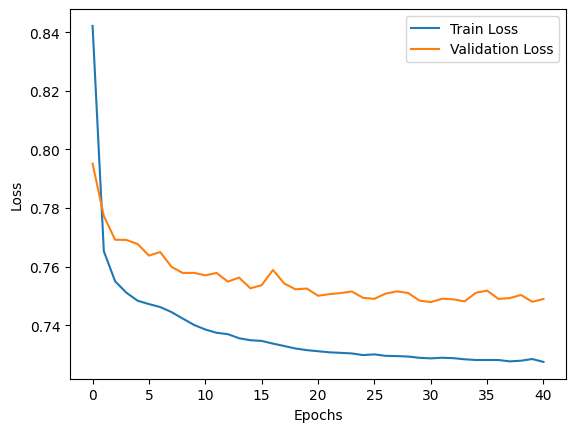

In [16]:
# График `loss`
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
# Получаем предсказания
predictions = autoencoder.predict(X_test)

3561/3561 ━━━━━━━━━━━━━━━━━━━━ 2s 659us/step


In [18]:
# Вычисляем среднеквадратичную ошибку (MSE)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)

# Вычисляем среднюю абсолютную ошибку (MAE)
mae = np.mean(np.abs(X_test - predictions), axis=1)

error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': y_test})
error_df.describe()

,reconstruction_error,true_class
count,113923.000000,113923.000000
mean,0.740498,0.001677
std,3.376126,0.040912
min,0.032091,0.000000
25%,0.242978,0.000000
50%,0.399780,0.000000
75%,0.636267,0.000000
max,270.617118,1.000000


In [19]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

print(f"ROCAUC: {roc_auc:.4f}")

ROCAUC: 0.9554


In [20]:
# Вычисляем PR-кривую
precision, recall, pr_thresholds = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)

# Вычисляем AUPRC
auprc = auc(recall, precision)

print(f"AUPRC: {auprc:.4f}")

AUPRC: 0.2374


In [21]:
# Найдем точку, где разница между true positive rate (TPR) и false positive rate (FPR) максимальна
optimal_idx_roc = np.argmax(tpr - fpr)
optimal_threshold_roc = thresholds[optimal_idx_roc]

print(f"Оптимальный порог по ROC: {optimal_threshold_roc:.4f}")

Оптимальный порог по ROC: 1.3276


In [22]:
# Вычисляем F1-score для каждого порога
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)  # 1e-9 предотвращает деление на 0
optimal_idx = f1_scores.argmax()  # Индекс наилучшего F1-score
optimal_threshold_pr = pr_thresholds[optimal_idx]

print(f"Оптимальный порог по PR-кривой: {optimal_threshold_pr:.6f}")

Оптимальный порог по PR-кривой: 60.548209


In [23]:
# Если ошибка выше порога – считаем мошенничеством
df["Fraud_Predicted"] = (error_df["reconstruction_error"] > optimal_threshold_roc).astype(int)
threshold = optimal_threshold_roc * 1.9
print(threshold)
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]

2.5224710291076753


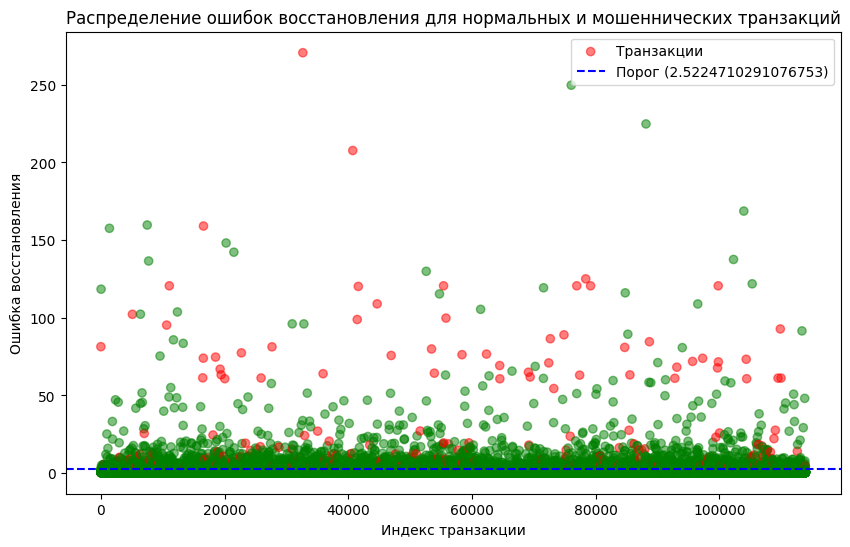

In [24]:
# Построение графика
plt.figure(figsize=(10, 6))

# Рисуем точки: зелёные - обычные транзакции, красные - мошенничество
plt.scatter(range(len(error_df.reconstruction_error.values)), error_df.reconstruction_error.values, 
            c=['green' if cls == 0 else 'red' for cls in error_df.true_class], alpha=0.5, label="Транзакции")

# Линия порога
plt.axhline(y=threshold, color='blue', linestyle='--', label=f"Порог ({threshold})")

# Настройки графика
plt.xlabel("Индекс транзакции")
plt.ylabel("Ошибка восстановления")
plt.title("Распределение ошибок восстановления для нормальных и мошеннических транзакций")
plt.legend()
plt.show()

In [25]:
# Создаем DataFrame с результатами
results = pd.DataFrame({
    # "Index": y_test.index,  # Индексы строк
    "True_Class": y_test.values,  # Истинные классы
    "Predicted_Class": y_pred  # Предсказанные классы
})

# Сохраняем в CSV
results.to_csv("predictions.csv", index=False)

print("Файл predictions.csv успешно сохранен!")

Файл predictions.csv успешно сохранен!


In [26]:
# Загружаем предсказания
df_pred = pd.read_csv("predictions.csv")

# Подсчет совпадений
correct_0 = len(df_pred[(df_pred["True_Class"] == 0) & (df_pred["Predicted_Class"] == 0)])
incorrect_0 = len(df_pred[(df_pred["True_Class"] == 0) & (df_pred["Predicted_Class"] == 1)])

correct_1 = len(df_pred[(df_pred["True_Class"] == 1) & (df_pred["Predicted_Class"] == 1)])
incorrect_1 = len(df_pred[(df_pred["True_Class"] == 1) & (df_pred["Predicted_Class"] == 0)])

# Вывод результатов
print("Класс 0:")
print(f"\tПравильных предсказаний: {correct_0}")
print(f"\tНеправильных предсказаний: {incorrect_0}")

print("Класс 1:")
print(f"\tПравильных предсказаний: {correct_1}")
print(f"\tНеправильных предсказаний: {incorrect_1}")

Класс 0:
	Правильных предсказаний: 110772
	Неправильных предсказаний: 2960
Класс 1:
	Правильных предсказаний: 160
	Неправильных предсказаний: 31


In [27]:
# Отбираем данные выше порога
high_error_df = error_df[error_df['reconstruction_error'] > threshold]

# Формируем X (фичи) и y (истинные классы)
X_high_error = X_test[error_df['reconstruction_error'] > threshold]
y_high_error = high_error_df['true_class']

In [28]:
X_train_high, X_test_high, y_train_high, y_test_high = train_test_split(
    X_high_error, y_high_error, test_size=0.2, random_state=42
)

In [29]:
# Создаём модель
classifier = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_high.shape[1],)),
    Dropout(0.3),  
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Выходной слой (бинарная классификация)
])

C:\Users\timma\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [30]:
# Компилируем модель
classifier.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [31]:
# Обучаем
classifier.fit(X_train_high, y_train_high, epochs=50, batch_size=16, validation_data=(X_test_high, y_test_high))

Epoch 1/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4835 - loss: 1.6355 - val_accuracy: 0.9583 - val_loss: 0.1191
Epoch 2/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9433 - loss: 0.2020 - val_accuracy: 0.9824 - val_loss: 0.0593
Epoch 3/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9674 - loss: 0.1146 - val_accuracy: 0.9824 - val_loss: 0.0476
Epoch 4/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9706 - loss: 0.0966 - val_accuracy: 0.9840 - val_loss: 0.0418
Epoch 5/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9766 - loss: 0.0628 - val_accuracy: 0.9872 - val_loss: 0.0397
Epoch 6/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9800 - loss: 0.0630 - val_accuracy: 0.9856 - val_loss: 0.0382
Epoch 7/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step - accuracy: 0.9793 - loss: 0.0577 - val_accuracy: 0.9872 - val_loss: 0.0390
Epoch 8/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9830 - loss: 0.0551 - val_accuracy: 

In [32]:
y_pred_high = (classifier.predict(X_test_high) > 0.5).astype(int)
print(classification_report(y_test_high, y_pred_high))

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       591
           1       0.84      0.94      0.89        33

    accuracy                           0.99       624
   macro avg       0.92      0.96      0.94       624
weighted avg       0.99      0.99      0.99       624



In [33]:
results_high = pd.DataFrame({
    "True_Class": y_test_high,  # Истинные классы
    "Predicted_Class": y_pred_high.flatten()  # Предсказанные классы
})

# Подсчет совпадений
correct_0_high = len(results_high[(results_high["True_Class"] == 0) & (results_high["Predicted_Class"] == 0)])
incorrect_0_high = len(results_high[(results_high["True_Class"] == 0) & (results_high["Predicted_Class"] == 1)])

correct_1_high = len(results_high[(results_high["True_Class"] == 1) & (results_high["Predicted_Class"] == 1)])
incorrect_1_high = len(results_high[(results_high["True_Class"] == 1) & (results_high["Predicted_Class"] == 0)])

# Вывод результатов
print("Класс 0:")
print(f"\tПравильных предсказаний: {correct_0_high}")
print(f"\tНеправильных предсказаний: {incorrect_0_high}")

print("Класс 1:")
print(f"\tПравильных предсказаний: {correct_1_high}")
print(f"\tНеправильных предсказаний: {incorrect_1_high}")

Класс 0:
	Правильных предсказаний: 585
	Неправильных предсказаний: 6
Класс 1:
	Правильных предсказаний: 31
	Неправильных предсказаний: 2
